# Trabajo Práctico 2: Análisis con Support Vector Machine (SVM) - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [15]:
import pandas as pd
import numpy as np

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [17]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [18]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [19]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [20]:
X, y = dividir_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train, X_test = normalizar_datos(X_train, X_test)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros mediante la siguiente función de búsqueda. Estos son 'kernel' y'C'. Nos quedamos con la combinación que maximice la métrica de comparación utilizada, que es AUC-ROC.

In [21]:
def definir_mejores_hiperparametros(X, y):    
    metrics = []
    for kernel in ['poly', 'rbf']:
        for C in [0.1, 1, 10]:
            print(C)
            if kernel == 'poly':
                svm = SVC(kernel = kernel, C = C, degree = 3, probability = True)
            else:
                svm = SVC(kernel = kernel, C = C, probability = True)
            svm.fit(X_train, y_train)
            y_pred = svm.predict_proba(X_test)[:, 1]

            print(f"Score de la combinación: {roc_auc_score(y_test, y_pred)}")
            metrics.append((C, kernel, roc_auc_score(y_test, y_pred)))
                
    df_metrics = pd.DataFrame(metrics, columns=['C', 'kernel', 'rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

In [22]:
def definir_mejor_gamma(X, y,mejor_C,mejor_kernel):    
    metrics = []    
    for gamma in ['scale',0.0001,0.0001,0.01,0.1]:
        print(gamma)
        svm = SVC(kernel = mejor_kernel, C = mejor_C,gamma = gamma ,probability = True)
        svm.fit(X_train, y_train)
        y_pred = svm.predict_proba(X_test)[:, 1]
        print(f"Score de la combinación: {roc_auc_score(y_test, y_pred)}")
        metrics.append((gamma, roc_auc_score(y_test, y_pred)))
                
    df_metrics = pd.DataFrame(metrics, columns=['gamma', 'rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [23]:
mejor_combinacion = definir_mejores_hiperparametros(X, y)
print(mejor_combinacion)

0.1
Score de la combinación: 0.8951520413712043
1
Score de la combinación: 0.8943558678537099
10
Score de la combinación: 0.8911215716575007
0.1
Score de la combinación: 0.89705306026687
1
Score de la combinación: 0.8984506442050545
10
Score de la combinación: 0.8951868980263843
     C kernel    rocauc
4  1.0    rbf  0.898451


Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [24]:
parametros_svm = mejor_combinacion.loc[:].values[0]
mejor_C = parametros_svm[0]
mejor_kernel = parametros_svm[1]
print(f'Mejor C: {mejor_C}')
print(f'Mejor kernel: {mejor_kernel}')

Mejor C: 1.0
Mejor kernel: rbf


In [31]:
mejor_parametro_rbf = definir_mejor_gamma(X, y,mejor_C,mejor_kernel)
print(mejor_parametro_rbf)

scale
Score de la combinación: 0.8984700590752722
0.0001
Score de la combinación: 0.8812919539371146
0.0001
Score de la combinación: 0.8812888410043369
0.01
Score de la combinación: 0.9009436937634357
0.1
Score de la combinación: 0.8987094272220073
  gamma    rocauc
3  0.01  0.900944


In [57]:
mejor_parametro_rbf = mejor_parametro_rbf.loc[:].values[0]
mejor_gamma = mejor_parametro_rbf[0]
print(f'Mejor gamma: {mejor_gamma}')

0.01

Entrenamos Support Vector Machine con esa mejor combinación. En el caso de que esta sea con kernel polinómico, utilizamos un kernel de grado 3.

In [58]:
svm = SVC(kernel = mejor_kernel,gamma = mejor_gamma ,C = mejor_C, probability=True)    
    
svm.fit(X_train, y_train)

SVC(gamma=0.01, probability=True)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

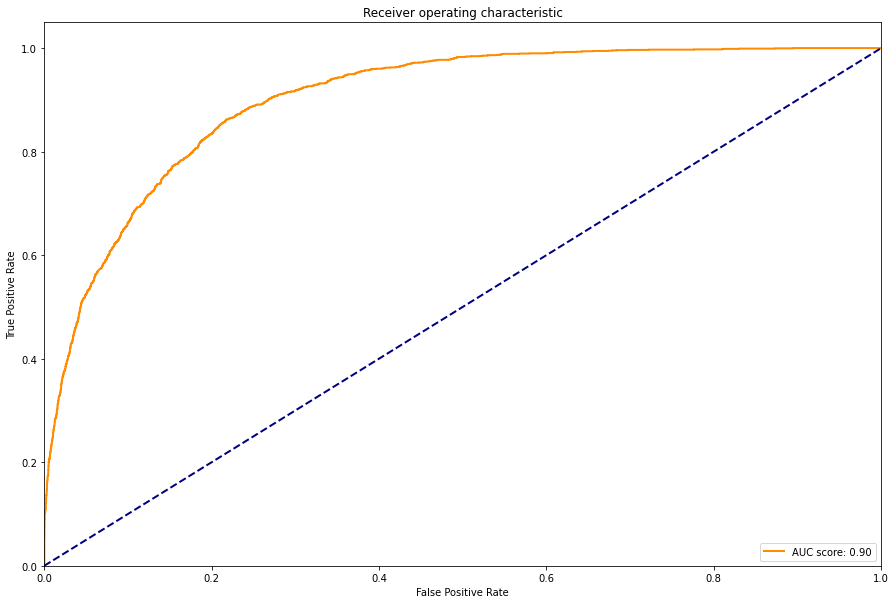

0.9009452502298246

In [59]:
y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)[:, 1]
graficar_auc_roc(y_test,y_pred_proba)

Podemos observar que dio un valor bastante alto, lo que es interesante, pues en esta métrica 1 significa un clasificador ideal.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [60]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.87      0.94      0.90      6159
   Tiene Alto Valor Adquisitivo       0.75      0.56      0.64      1982

                       accuracy                           0.85      8141
                      macro avg       0.81      0.75      0.77      8141
                   weighted avg       0.84      0.85      0.84      8141



Por último, mostramos la matriz de confusión correspondiente:

In [61]:
from funcionesAuxiliares import graficar_matriz_confusion

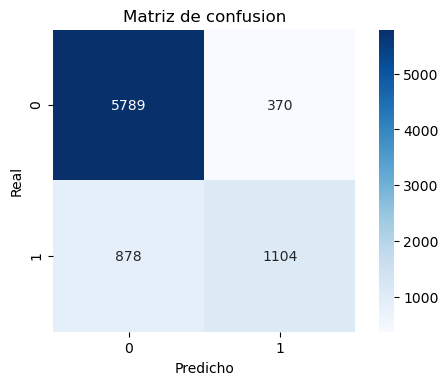

In [62]:
graficar_matriz_confusion(y_test, y_pred)

Podemos ver que SVM es un muy buen clasificador para los contribuyentes con bajo valor adquisitivo. Además, es relativamente bueno para aquellas instancias con alto valor adquisitivo, ya que predice bien la mayoría, pero hay una buena cantidad que no predijo bien.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [63]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [64]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [65]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp, y)

0.1
Score de la combinación: 0.8951530653622496
1
Score de la combinación: 0.8943591446250546
10
Score de la combinación: 0.8911184996843651
0.1
Score de la combinación: 0.8970525277915267
1
Score de la combinación: 0.8984653077568223
10
Score de la combinación: 0.8952109822957683


A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [66]:
parametros_svm = mejor_combinacion.loc[:].values[0]
mejor_C = parametros_svm[0]
mejor_kernel = parametros_svm[1]
print(f'Mejor C: {mejor_C}')
print(f'Mejor kernel: {mejor_kernel}')

Mejor C: 1.0
Mejor kernel: rbf


In [67]:
mejor_parametro_rbf = definir_mejor_gamma(X, y,mejor_C,mejor_kernel)
print(mejor_parametro_rbf)

scale
Score de la combinación: 0.8984690760438687
0.0001
Score de la combinación: 0.8812894144393223
0.0001
Score de la combinación: 0.8812882675693515
0.01
Score de la combinación: 0.9009432432073758
0.1
Score de la combinación: 0.8987304804778975
  gamma    rocauc
3  0.01  0.900943


In [68]:
mejor_parametro_rbf = mejor_parametro_rbf.loc[:].values[0]
mejor_gamma = mejor_parametro_rbf[0]
print(f'Mejor gamma: {mejor_gamma}')

Mejor gamma: 0.01


Entrenamos Support Vector Machine con esa mejor combinación. En el caso de que esta sea con kernel polinómico, utilizamos un kernel de grado 3.

In [69]:
svm_expandido = SVC(kernel = mejor_kernel,gamma = mejor_gamma ,C = mejor_C, probability=True)  
    
svm_expandido.fit(X_exp_train, y_exp_train)

SVC(gamma=0.01, probability=True)

Y ahora hacemos que prediga sobre el dataset expandido. Graficamos también la curva ROC con su respectivo resultado en la métrica AUC-ROC.

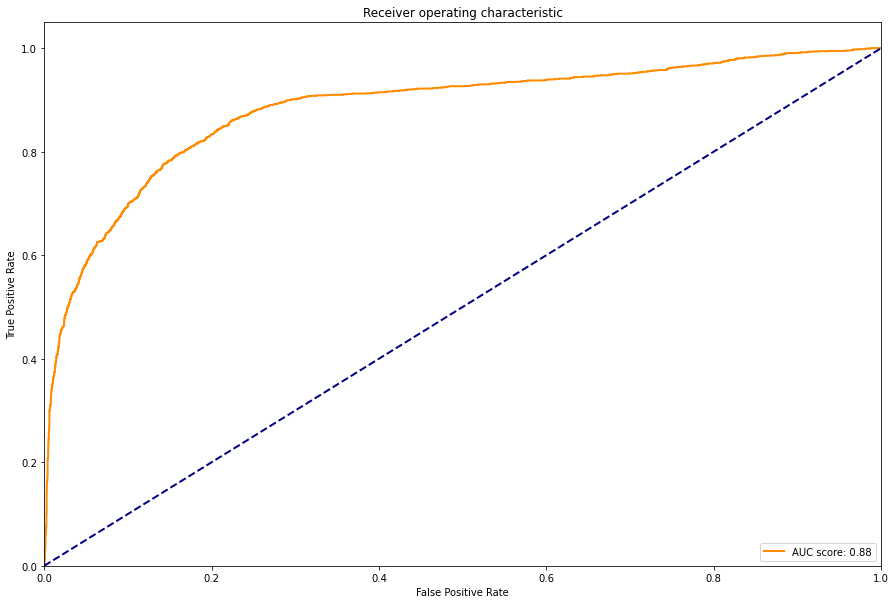

0.883599538237382

In [70]:
y_pred = svm_expandido.predict(X_exp_test)
y_pred_proba = svm_expandido.predict_proba(X_exp_test)[:, 1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos ver que el AUC score dio un valor elevado. Sin embargo, este es considerablemente menor al de la predicción con el dataset original, con una diferencia de un 4% aproximadamente.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [71]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.87      0.96      0.91      6159
   Tiene Alto Valor Adquisitivo       0.82      0.54      0.65      1982

                       accuracy                           0.86      8141
                      macro avg       0.84      0.75      0.78      8141
                   weighted avg       0.85      0.86      0.85      8141



Se puede rescatar un recall alto para las instancias que no tienen alto valor adquisitivo, pero un recall muy bajo (0.28) para las instancias que si tienen alto valor adquisitivo. Esto se puede ver claramente en la siguiente matriz de confusión, donde la mayoría de los ceros reales se predijo correctamente, pero no se puede decir lo mismo sobre los unos:

In [72]:
from funcionesAuxiliares import graficar_matriz_confusion

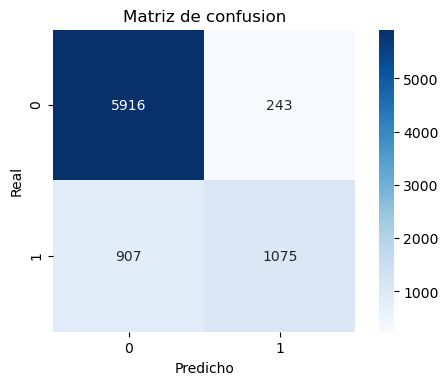

In [73]:
graficar_matriz_confusion(y_exp_test, y_pred)

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con SVM sobre el dataset de holdout sin expandir, ya que es el que nos dio un score más alto en la métrica AUC-ROC, y la escribimos al archivo 'SVM.csv'.

In [77]:
from funcionesAuxiliares import traer_holdout
from preprocessing import preparar_holdout
from funcionesAuxiliares import escribir_predicciones

In [78]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)
holdout = aplicar_one_hot_encoding(holdout)

In [79]:
predicciones = svm.predict(holdout)
escribir_predicciones(ids, predicciones, "SVM")